In [12]:
%%javascript
IPython.notebook.get_cells().map( function(c) {  return c.code_mirror.options.cursorBlinkRate=0;  } );
CodeMirror.defaults.cursorBlinkRate=0;

<IPython.core.display.Javascript object>

# COCOA Examples

Running COCOA using its docker image. If you haven't pulled the image yet, you can use

    docker pull --name cocoa ghcr.io/cocoa-hep/cocoa-hep:main
    docker tag ghcr.io/cocoa-hep/cocoa-hep:main cocoa
    sudo docker image rm ghcr.io/cocoa-hep/cocoa-hep:main

to do so and restart this notebook.

# Linux and permissions

On Linux you might need to prepare user permissions to run the docker client as done below. One way do do this is to

    sudo groupadd docker
    sudo gpasswd -a $USER docker
    newgrp docker

In [113]:
import docker

client = docker.from_env()

cmd1 = "cd /root/COCOA/COCOA"
cmd2 = "/root/COCOA/build/COCOA -c config/config_default.json -m macro/Pythia8/ChargedPion_monochromatic_isotropic.in -n 100 -o /root/COCOA/pions.root"
cmd3 = "cp /root/COCOA/pions.root /mnt/host_tmp"

command = 'bash -c "{} && {} && {}"'.format(cmd1, cmd2, cmd3)

In [124]:
def run_cocoa(command, volumes, show_output = True):
    container = client.containers.run("cocoa", command=command, volumes = volumes, detach = True)
    if show_output:
        for line in container.logs(stream=True):
            print(line)

In [127]:
run_cocoa( command, ["/tmp:/mnt/host_tmp"], False )

In [126]:
macro_single_photon = open("/tmp/photon.in", "w")
macro_single_photon.write("/generator/select pythia8\n")
macro_single_photon.write("/generator/pythia8/verbose 0\n")
macro_single_photon.write("/tracking/storeTrajectory 1\n")
macro_single_photon.write("/generator/pythia8/QuarkGluon 22\n") # 22 = photon PDG id
macro_single_photon.write("/generator/pythia8/minEnergy 20\n")
macro_single_photon.write("/generator/pythia8/maxEnergy 20\n")
macro_single_photon.write("/generator/pythia8/minEta -2.5\n")
macro_single_photon.write("/generator/pythia8/maxEta 2.5\n")
macro_single_photon.write("/run/beamOn 10\n")
macro_single_photon.close()

cmd1 = "cp /mnt/host_tmp/photon.in /root/COCOA/COCOA"
cmd2 = "cd /root/COCOA/COCOA"
cmd3 = "/root/COCOA/build/COCOA -c config/config_default.json -m photon.in -n 100 -o /root/COCOA/photons.root"
cmd4 = "cp /root/COCOA/photons.root /mnt/host_tmp"

command = 'bash -c "{} && {} && {} && {}"'.format(cmd1, cmd2, cmd3, cmd4)

run_cocoa( command, ["/tmp:/mnt/host_tmp"], False )

# Example plots: cell vs. particle energy, $\eta$ and $\varphi$

In [108]:
import numpy as np
import uproot

# code duplication : to be made more efficient and safe

pions_tree        = uproot.open("/tmp/pions.root:Out_Tree")
pions_cell_e      = pions_tree.arrays( [ "cell_e" ], library = "np" )
pions_n_particles = pions_cell_e["cell_e"].shape[0]
pions_particle_e  = tree.arrays( [ "particle_e" ], library = "np" )
pions_residual_e = [ pions_cell_e["cell_e"][i_prt].sum() / pions_particle_e["particle_e"][i_prt][0] - 1.0 for i_prt in range(pions_n_particles)]

photons_tree        = uproot.open("/tmp/photons.root:Out_Tree")
photons_cell_e      = photons_tree.arrays( [ "cell_e" ], library = "np" )
photons_n_particles = photons_cell_e["cell_e"].shape[0]
photons_particle_e  = tree.arrays( [ "particle_e" ], library = "np" )
photons_residual_e = [ photons_cell_e["cell_e"][i_prt].sum() / photons_particle_e["particle_e"][i_prt][0] - 1.0 for i_prt in range(photons_n_particles)]

In [120]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (6.0, 6.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["figure.facecolor"] = "White"
plt.rcParams["font.size"] = 12

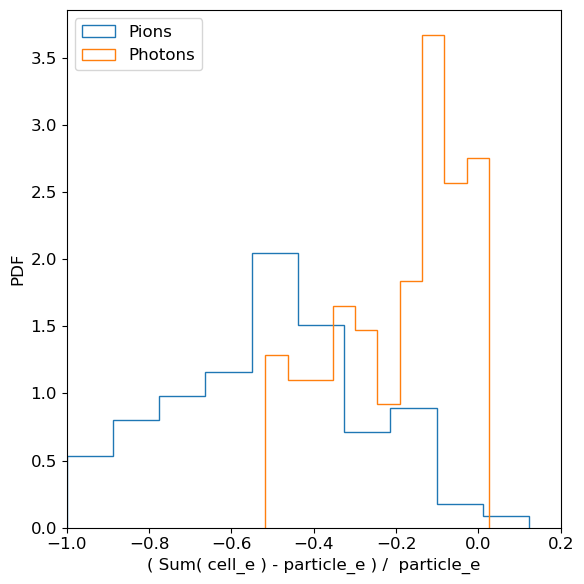

In [123]:
plt.hist(
         pions_residual_e,
         histtype="step",
         density=True,
         label = "Pions"
)

plt.hist(
         photons_residual_e,
         histtype="step",
         density=True,
         label = "Photons"
)
ax = plt.gca()
ax.set(xlabel="( Sum( cell_e ) - particle_e ) /  particle_e", ylabel="PDF")
ax.set_xlim(-1.0, 0.2)

plt.legend()
plt.tight_layout()
plt.show()